# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using LaTeXStrings
@everywhere using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns
using StatsPlots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [5]:
df = CSV.read("data/section10a.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ, 白丸は生存確率0.504の二項分布. 二項分布では観測データのばらつきが説明できていない

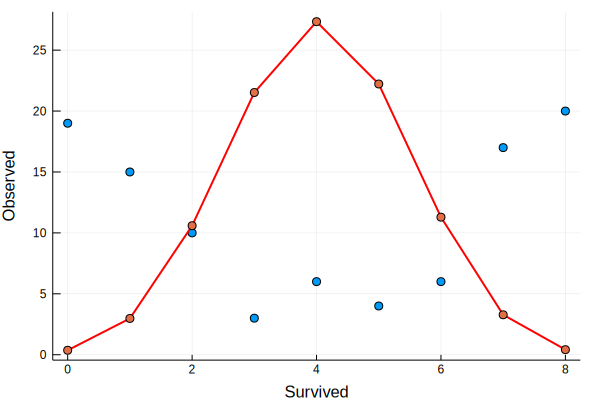

In [7]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング
### モデルの作成

In [6]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) -> 
            UnivariateDistribution[
                Normal(0, s) for i in 1:N
            ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

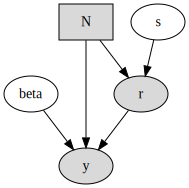

In [8]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [9]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

### 初期値の設定

In [10]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.143875, 0.0034757, -0.0295217, 0.0338177, 0.125514, -0.0183196, -0.114757, -0.0107311, -0.023769, -0.0948071  …  0.00550499, 0.0778624, 0.00476725, -0.0138662, 0.0240516, 0.05979, 0.0504161, -0.165839, 0.0505529, -0.0175426])       
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0467297, 0.18892, 0.0704031, -0.0573782, -0.185504, 0.0421399, -0.23069, 0.04943, -0.0818038, -0.0383022  …  0.0131986, 0.103352, -0.03294, 0.0547772, -0.1314, 0.0240294, 0.064408, 0.223398, -0.0979327, -0.0150545])                 
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0428511, 0.0524587, 0.00991471, -0.0501458, -0.107661, -0.0210182, 0.0777308, -0.103509, 0.0583944, -0.00783696  …  0.0579787, 0.0941609, -0.00521566, 0.0564492, 0.0178251, 0.0788087, 0.0814671, 0

### MCMCサンプル方法の設定
NUTSを使うと遅くなってしまったので、AMWGを使用

In [11]:
scheme = [
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                           
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                   

### MCMCサンプリング
サンプリングは21000回実施し, burn-inの数は1000, 10飛ばしの結果の記録を3チェイン行うので、サンプルの数は(21000-1000)/10*3=6000個

In [12]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 21000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 4:	Chain 3:   0% [2:34:15 of 2:34:20 remaining]
      From worker 2:	Chain 1:   0% [2:38:11 of 2:38:16 remaining]
      From worker 3:	Chain 2:   0% [2:43:45 of 2:43:49 remaining]
      From worker 4:	Chain 3:  10% [0:03:13 of 0:03:35 remaining]
      From worker 2:	Chain 1:  10% [0:03:14 of 0:03:35 remaining]
      From worker 3:	Chain 2:  10% [0:03:18 of 0:03:40 remaining]
      From worker 2:	Chain 1:  20% [0:02:33 of 0:03:11 remaining]
      From worker 3:	Chain 2:  20% [0:02:33 of 0:03:12 remaining]
      From worker 4:	Chain 3:  20% [0:02:34 of 0:03:12 remaining]
      From worker 3:	Chain 2:  30% [0:02:08 of 0:03:04 remaining]
      From worker 4:	Chain 3:  30% [0:02:09 of 0:03:04 remaining]
      From worker 2:	Chain 1:  30% [0:02:09 of 0:03:04 remaining]
      From worker 3:	Chain 2:  40% [0:01:47 of 0:02:59 remaining]
      From worker 4:	Chain 3:  40% [0:01:48 of 0:03:01 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[2.89554 -0.416186; 3.07993 -0.272344; … ; 4.17844 0.476798; 2.69401 0.310094]

[3.69526 0.77958; 3.46428 0.654744; … ; 2.75734 0.0472923; 3.55904 -0.102328]

[3.71103 -0.252919; 3.47925 -0.601233; … ; 3.0551 0.12835; 2.5903 0.174678]

### サンプリング結果を表示

In [13]:
describe(sim)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE       ESS   
   s 3.025739941 0.37548050 0.0048474324 0.007725367 2000.0000
beta 0.047785832 0.34536775 0.0044586784 0.011654686  878.1372

Quantiles:
        2.5%       25.0%       50.0%      75.0%      97.5%  
   s  2.3764549  2.75951086 3.00240806 3.25495188 3.84686086
beta -0.6170343 -0.18690047 0.04673276 0.27372235 0.72312518



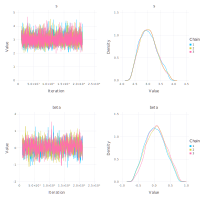

In [14]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

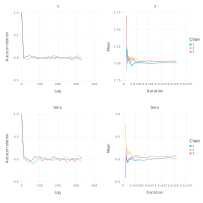

In [15]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

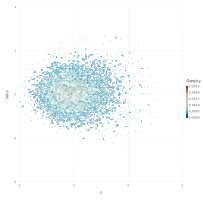

In [16]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
$p(y \mid \beta, r)p(r \mid s)$を求める関数

In [17]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

$p(y \mid \beta, s) = \int_{-\infty}^\infty p(y \mid \beta, r)p(r \mid s)dr$を求める関数. 
実際は$\int_{-10s}^{10s} p(y \mid \beta, r)p(r \mid s)dr$を求めている

In [18]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \ldots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [19]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

6000-element Array{Array{Float64,1},1}:
 [0.248258, 0.118888, 0.0843251, 0.0708335, 0.0660359, 0.0671443, 0.0751768, 0.0973379, 0.172]   
 [0.245407, 0.111854, 0.0789799, 0.0666438, 0.062685, 0.0645961, 0.0738503, 0.0994295, 0.196554] 
 [0.2305, 0.107715, 0.0771318, 0.065785, 0.0624855, 0.0650523, 0.0752947, 0.103254, 0.212782]    
 [0.270548, 0.105286, 0.0716852, 0.0597407, 0.0560496, 0.0580421, 0.067355, 0.0942616, 0.217032] 
 [0.233977, 0.108722, 0.0775993, 0.0660173, 0.0625609, 0.0649723, 0.0749798, 0.102366, 0.208805] 
 [0.217953, 0.0997338, 0.0718001, 0.0618273, 0.0594386, 0.0628473, 0.0743783, 0.106139, 0.245882]
 [0.215835, 0.0969259, 0.0696706, 0.0600869, 0.0579418, 0.0615486, 0.0733794, 0.10624, 0.258372] 
 [0.244509, 0.095071, 0.0657731, 0.0557258, 0.0532125, 0.056259, 0.0671426, 0.0986333, 0.263674] 
 [0.20899, 0.0981438, 0.0713708, 0.0618476, 0.0597551, 0.0634686, 0.0754643, 0.108285, 0.252675] 
 [0.207022, 0.103324, 0.0760035, 0.0659409, 0.0634876, 0.0669163, 0.0784422, 0

各パスに対して、$P(X=y)=p(y \mid \beta, s)\ \text{for}\ y = 0, \ldots, 8$というCategorical distributionから100個体のサンプリングを行い, $y$ごとに出現回数を数える. 横方向は各サンプリング, 縦方向は$y = 0, \ldots, 8$の出現回数に該当

In [20]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×6000 Array{Int64,2}:
 34  25  30  25  19  14  12  16  15  …  18  29  36  23  26  34  26  24  17
 11   7  13  11  11  11  16  14   5     11   9  12  11  11  10  10  14  14
  5   5   7   5  10   7   8   6   9      8   7  12   8  11   5  13   5  17
  8   8   4  12   5   7   5   7  11     10   6   4   7   8   7   6   8   4
  8   5   5   3   2   5  12   4   4     10   8   7  10   5   9   5   7   5
  5   8   8   4   5   5   7   7   3  …   9   8   3  13   5   4   4   5   5
  5   7   8   7  11  10   6   8  10      8  11   5   8   6  10   7  13   7
 10  14  11  15  15  14  13  14  14     11  10   4   8   8  12  13  10  11
 14  21  14  18  22  27  21  24  29     15  12  17  12  20   9  16  14  20

$y$毎に出現回数の2.5%, 50%, 97.5%点を計算

In [21]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  7.0
  6.0
  7.0
  8.0
 11.0
 22.0

### 生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

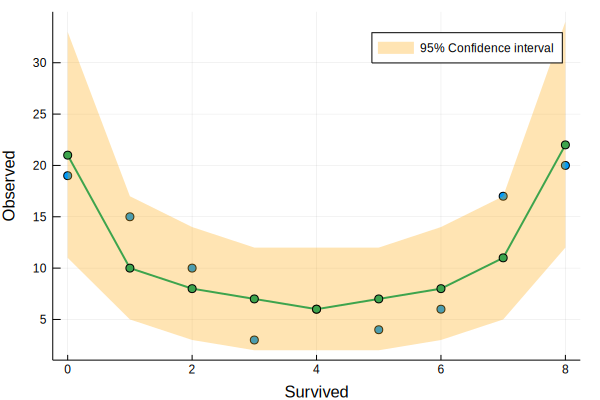

In [22]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile_sample_0025, lw = 0, 
    fillrange = quantile_sample_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")

## 10.5 個体差 + 場所差の階層ベイズモデル

In [3]:
df2 = CSV.read("data/section10b.csv")
disallowmissing!(df2)

,id,pot,f,y
,Int64,String,String,Int64
1,1,A,C,6
2,2,A,C,3
3,3,A,C,19
4,4,A,C,5
5,5,A,C,0
6,6,A,C,19
7,7,A,C,4
8,8,A,C,8
9,9,A,C,12


In [4]:
marker_dict = Dict(
    "A" => :circle,
    "B" => :ltriangle,
    "C" => :star5,
    "D" => :diamond,
    "E" => :dtriangle,
    "F" => :xcross,
    "G" => :star4,
    "H" => :utriangle,
    "I" => :rect,
    "J" => :rtriangle
)

Dict{String,Symbol} with 10 entries:
  "B" => :ltriangle
  "A" => :circle
  "I" => :rect
  "J" => :rtriangle
  "C" => :star5
  "D" => :diamond
  "G" => :star4
  "E" => :dtriangle
  "F" => :xcross
  "H" => :utriangle

### 個体ごとの表示
赤線は無処理、青線は堆肥処理した個体の平均

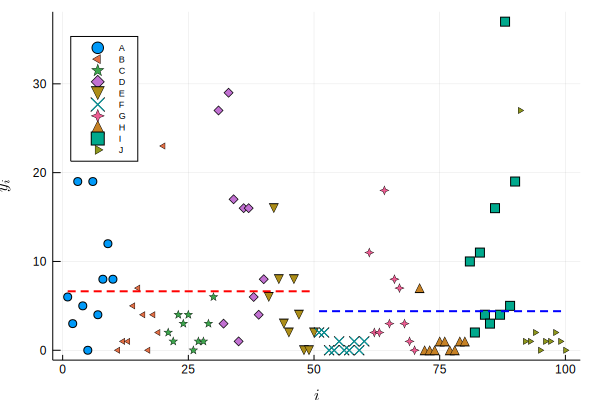

In [5]:
plt = Plots.plot()
for k in sort(collect(keys(marker_dict)))
    df_k = df2[df2[:pot] .== k, :]
    scatter!(df_k.id, df_k.y, label = k, markershape = marker_dict[k],
        legend = :topleft, legendfontsize = 6, xlabel = L"i", ylabel = L"y_i")
end
plot!(1:50, fill(mean(df2[1:50, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :red, label = "")
plot!(51:100, fill(mean(df2[51:100, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :blue, label = "")
plt

### 植木鉢毎に箱ひげ図として図示

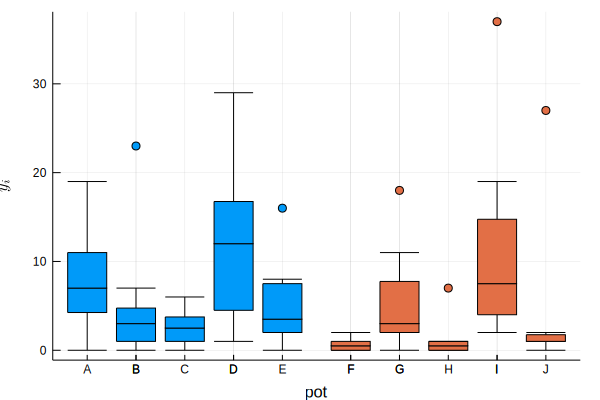

In [6]:
boxplot(df2[1:50, :].pot, df2[1:50, :].y, label = "")
boxplot!(df2[51:100, :].pot, df2[51:100, :].y, label = "", xlabel = "pot", ylabel = L"y_i")

### GLMM化したポアソン回帰
個体$i$の種子数$y_i$を平均$\lambda_i$のポアソン回帰
\begin{align}
p(y_i \mid \lambda_i) = \frac{\lambda_i^{y_i}\exp(-\lambda_i)}{y_i!}
\end{align}
で表現し, 平均種子数は切片$\beta_1$, 堆肥処理の有無を表す因子型の説明変数$f_i$の係数$\beta_2$, 個体$i$の効果$r_i$と植木鉢$j$の効果$t_{j(i)}$で
\begin{align}
\log \lambda_i = \beta_1 + \beta_2 f_i + r_i + t_{j(i)}
\end{align}
で表現.

\begin{align}
y_i & \sim \text{Poisson}(\lambda_i), \ i = 1, \ldots, 100 \\
\log \lambda_i & = \beta_1 + \beta_2 f_i + r_i + t_{j(i)} \\
\beta_1, \beta_2 & \sim \text{Normal}(0, 100) \\
r_i & \sim \text{Normal}(0, s_r^2) \\
t_j & \sim \text{Normal}(0, s_t^2), j = 1,\ldots, 10 \\
s_r, s_t & \sim \text{Uniform}(0, 10000)
\end{align}

In [7]:
model2 = Model(
    
    y = Stochastic(1,
        (beta1, beta2, f, r, t, pot, N_r) ->
            UnivariateDistribution[
                (lambda = exp(beta1 + beta2 * f[i] + r[i] + t[pot[i]]);
                Poisson(lambda)) for i in 1:N_r
            ],
        false
    ),
    
    r = Stochastic(1,
        (s_r, N_r) -> 
            UnivariateDistribution[
                Normal(0, s_r) for i in 1:N_r
            ],
        false
    ),
    
    t = Stochastic(1,
        (s_t, N_t) -> 
            UnivariateDistribution[
                Normal(0, s_t) for i in 1:N_t
            ],
        false
    ),
    
    beta1 = Stochastic(() -> Normal(0, 100)),
    beta2 = Stochastic(() -> Normal(0, 100)),
    
    s_r = Stochastic(() -> Uniform(0, 10000)),
    s_t = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s_r:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s_t:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
t:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarS

### モデルの図示

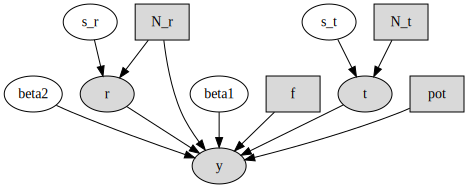

In [8]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model2)))

### 入力データの設定

In [9]:
pot_dict = Dict(string(y) => x for (x, y) in enumerate("ABCDEFGHIJ"))
f_dict = Dict("C" => 0, "T" => 1)
data2 = Dict{Symbol, Any}(
    :y => df2.y,
    :N_r => length(df2.y),
    :N_t => length(unique(df2.pot)),
    :pot => [pot_dict[x] for x in df2.pot],
    :f => [f_dict[x] for x in df2.f],
)

Dict{Symbol,Any} with 5 entries:
  :f   => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  :N_t => 10
  :y   => [6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0]
  :N_r => 100
  :pot => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10,…

### 初期値の設定

In [10]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df2.y,
        :beta1 => 0.0,
        :beta2 => 0.0,
        :r => rand(Normal(0, 0.1), data2[:N_r]),
        :t => rand(Normal(0, 0.1), data2[:N_t]),
        :s_r => 1.0,
        :s_t => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta2=>0.0,:s_r=>1.0,:y=>[6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t=>1.0,:beta1=>0.0,:r=>[0.0236166, 0.00452407, 0.00149433, -0.039065, 0.0391079, 0.0160548, -0.220585, -0.0114932, -0.0418748, 0.0457775  …  0.0408531, 0.0629708, 0.0857528, -0.0992369, 0.0718772, -0.0656146, -0.112488, -0.0325152, 0.0374435, 0.0224554],:t=>[-0.159346, 0.0981441, 0.0139074, 0.0676373, -0.0598743, -0.00891395, -0.0376987, -0.126371, 0.157044, 0.132874])  
 Dict(:beta2=>0.0,:s_r=>1.0,:y=>[6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t=>1.0,:beta1=>0.0,:r=>[-0.0523729, 0.0571751, -0.00634594, -0.0930009, 0.151436, 0.0736881, 0.106362, -0.00655384, 0.00531718, -0.136817  …  0.0684813, 0.190843, -0.0189908, 0.0504315, 0.0978693, -0.0482118, 0.0958955, -0.0183862, 0.0329715, -0.0614813],:t=>[0.0707073, -0.252351, -0.00155756, 0.0243406, 0.0348366, 0.0763462, -0.142731, -0.0405091, -0.190244, 0.0143451])
 Dict(:be

In [11]:
# scheme2 = [
#     AMWG(:t, 0.1),
#     Slice(:r, 0.1, Mamba.Univariate),
#     Slice(:s_r, 1.0, Mamba.Univariate),
#     Slice(:s_t, 1.0, Mamba.Univariate),
#     Slice([:beta1, :beta2], 1.0, Mamba.Univariate)
# ]

In [19]:
scheme2 = [
    AMWG([:r], 0.1), 
    AMWG([:t], 0.1),
    Slice([:s_r, :s_t], 0.1, Mamba.Univariate), 
    Slice([:beta1, :beta2], 1.0, Mamba.Univariate)
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:t]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, blo

In [20]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 22000, burnin = 2000, thin = 10, chains = 3)

MCMC Simulation of 22000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [0:09:28 of 0:09:29 remaining]
      From worker 2:	Chain 1:   0% [0:12:44 of 0:12:45 remaining]
      From worker 4:	Chain 2:   0% [0:06:55 of 0:06:55 remaining]
      From worker 2:	Chain 1:  10% [0:02:46 of 0:03:04 remaining]
      From worker 4:	Chain 2:  10% [0:02:44 of 0:03:02 remaining]
      From worker 3:	Chain 3:  10% [0:02:49 of 0:03:08 remaining]
      From worker 4:	Chain 2:  20% [0:02:20 of 0:02:55 remaining]
      From worker 2:	Chain 1:  20% [0:02:23 of 0:02:59 remaining]
      From worker 3:	Chain 3:  20% [0:02:24 of 0:03:00 remaining]
      From worker 4:	Chain 2:  30% [0:02:04 of 0:02:56 remaining]
      From worker 2:	Chain 1:  30% [0:02:05 of 0:02:58 remaining]
      From worker 3:	Chain 3:  30% [0:02:06 of 0:02:60 remaining]
      From worker 4:	Chain 2:  40% [0:01:48 of 0:03:00 remaining]
      From worker 2:	Chain 1:  40% [0:01:49 of 0:03:02 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[-0.996104 1.44329 0.833554 0.866892; -0.882016 1.46066 0.798555 0.966782; … ; -1.35146 1.61621 0.922924 1.07253; -1.06578 1.47402 1.05776 0.93244]

[-0.768557 1.92571 1.10011 1.04987; -0.66413 1.90929 1.36624 1.04224; … ; -0.27426 0.762044 1.21827 1.1022; -0.0742688 0.829874 1.42749 0.971679]

[-2.45092 2.17562 1.22531 1.10578; -2.26754 2.13399 1.27108 1.12466; … ; -0.910354 1.07642 0.630554 1.00342; -0.909218 1.19355 0.620781 1.04266]

### 事後分布を確認する
$\beta_2$の95%区間を見ると、堆肥処理の効果はなさそう

In [27]:
describe(sim2)

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE         ESS   
beta2 -0.8209018 0.75807938 0.0097867627 0.0645123106  138.08426
beta1  1.3565273 0.50895242 0.0065705475 0.0403119406  159.39950
  s_t  1.0470501 0.39276502 0.0050705746 0.0306199624  164.53424
  s_r  1.0173204 0.11379063 0.0014690307 0.0035649292 1018.85214

Quantiles:
          2.5%       25.0%       50.0%      75.0%      97.5%  
beta2 -2.34271381 -1.29820771 -0.8109805 -0.33493376 0.6708835
beta1  0.36736681  1.02437421  1.3504382  1.70318994 2.3853853
  s_t  0.51524976  0.77715357  0.9616505  1.23073153 2.0517733
  s_r  0.81674861  0.93660140  1.0118047  1.08937508 1.2575313



In [21]:
p = Mamba.plot(sim2, legend = true);

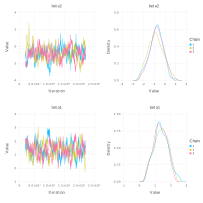

In [22]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

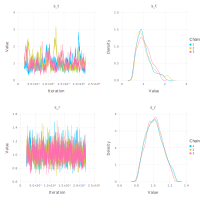

In [23]:
Mamba.draw(p[:, 3:4], nrow = 2, ncol = 2)

In [24]:
p = Mamba.plot(sim2, [:autocor, :mean], legend=true);

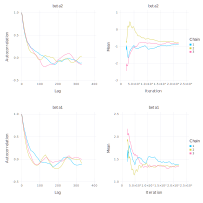

In [25]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

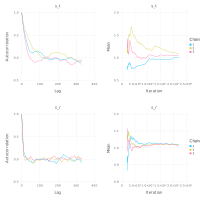

In [26]:
Mamba.draw(p[:, 3:4], nrow = 2, ncol = 2)